In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
import evaluate
import os
os.environ["WANDB_DISABLED"] = "true"
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path

In [ ]:
# Login using e.g. `huggingface-cli login` to access this dataset
df = pl.read_parquet('hf://datasets/sumuks/CodeNet-16K/data/train-00000-of-00001.parquet')

In [ ]:
# Display the first few rows of the DataFrame to inspect its structure
df.head()

shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ output_de ┆ submissio ┆ status    ┆ problem_i ┆ … ┆ attempt   ┆ problem_d ┆ samples   ┆ plan     │
│ scription ┆ n_id      ┆ ---       ┆ d         ┆   ┆ ---       ┆ escriptio ┆ ---       ┆ ---      │
│ ---       ┆ ---       ┆ str       ┆ ---       ┆   ┆ str       ┆ n         ┆ str       ┆ str      │
│ str       ┆ str       ┆           ┆ str       ┆   ┆           ┆ ---       ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ For each  ┆ s42220975 ┆ Runtime   ┆ p03466    ┆ … ┆ for t in  ┆ Statement ┆ [{"input" ┆          │
│ query i   ┆ 0         ┆ Error     ┆           ┆   ┆ range(int ┆           ┆ : "5\n    ┆          │
│ in order  ┆           ┆           ┆           ┆   ┆ (input()) ┆ Let f(A,  ┆ 2 3 1 5\n ┆ <thinkin │
│ of i…     ┆           ┆           ┆           ┆   ┆ ):        ┆ B), where ┆ …         ┆ g>       │
│           ┆           ┆           ┆           ┆   ┆ …         ┆ …         ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ To solve │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ this pr… │
│ Print 10  ┆ s99737029 ┆ Accepted  ┆ p03036    ┆ … ┆ R, D,     ┆ Statement ┆ [{"input" ┆          │
│ lines.    ┆ 2         ┆           ┆           ┆   ┆ X2000 =   ┆           ┆ : "2 10   ┆          │
│ The i-th  ┆           ┆           ┆           ┆   ┆ [int(i)   ┆ The devel ┆ 20",      ┆ <thinkin │
│ line …    ┆           ┆           ┆           ┆   ┆ for i in… ┆ opment of ┆ "output"… ┆ g>       │
│           ┆           ┆           ┆           ┆   ┆           ┆ …         ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ The      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ problem  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ is t…    │
│ Print 10  ┆ s83802260 ┆ Runtime   ┆ p03036    ┆ … ┆ #!        ┆ Statement ┆ [{"input" ┆          │
│ lines.    ┆ 2         ┆ Error     ┆           ┆   ┆ python3   ┆           ┆ : "2 10   ┆          │
│ The i-th  ┆           ┆           ┆           ┆   ┆ #  solve1 ┆ The devel ┆ 20",      ┆ <thinkin │
│ line …    ┆           ┆           ┆           ┆   ┆ 27A.py    ┆ opment of ┆ "output"… ┆ g>       │
│           ┆           ┆           ┆           ┆   ┆           ┆ …         ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ ag…       ┆           ┆           ┆ To solve │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ this pr… │
│ Print 10  ┆ s45796915 ┆ Accepted  ┆ p03036    ┆ … ┆ import    ┆ Statement ┆ [{"input" ┆          │
│ lines.    ┆ 2         ┆           ┆           ┆   ┆ sys       ┆           ┆ : "2 10   ┆          │
│ The i-th  ┆           ┆           ┆           ┆   ┆           ┆ The devel ┆ 20",      ┆ <thinkin │
│ line …    ┆           ┆           ┆           ┆   ┆ a = sys.s ┆ opment of ┆ "output"… ┆ g>       │
│           ┆           ┆           ┆           ┆   ┆ tdin.read ┆ …         ┆           ┆ To solve │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆ this     │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ pro…     │
│ Print 10  ┆ s91852808 ┆ Accepted  ┆ p03036    ┆ … ┆ r, d, x = ┆ Statement ┆ [{"input" ┆          │
│ lines.    ┆ 5         ┆           ┆           ┆   ┆ map(int,  ┆           ┆ : "2 10   ┆          │
│ The i-th  ┆           ┆           ┆           ┆   ┆ input().s ┆ The devel ┆ 20",      ┆ <thinkin │
│ line …    ┆           ┆           ┆          

In [ ]:
# df as  Polars DataFrame
unique_status_count = df['status'].n_unique()
print(f"Number of unique statuses: {unique_status_count}")

Number of unique statuses: 3


In [ ]:
# Get the unique values from the 'status' column
unique_statuses = df['status'].unique()
print(unique_statuses)

shape: (3,)
Series: 'status' [str]
[
	"Runtime Error"
	"Accepted"
	"Wrong Answer"
]


In [ ]:
# Count how many times each unique status appear in the DataFrame
df['status'].value_counts()

shape: (3, 2)
┌───────────────┬───────┐
│ status        ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ Accepted      ┆ 3962  │
│ Runtime Error ┆ 9013  │
│ Wrong Answer  ┆ 3566  │
└───────────────┴───────┘

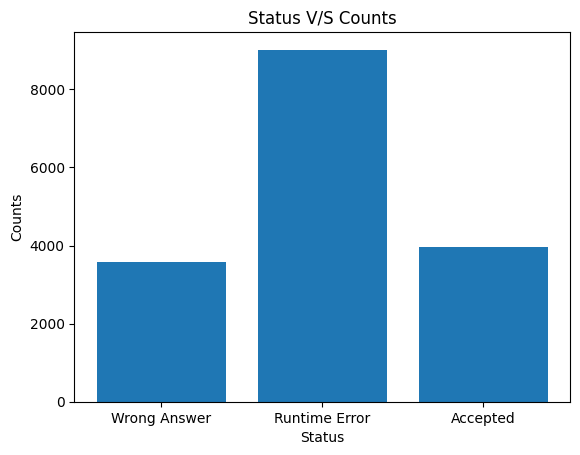

In [ ]:
# Get the count of each unique status in the DataFrame
df_status = df['status'].value_counts()

# Extract status labels and their corresponding counts
status = df_status['status']
status_values = df_status['count']

# Plot the distribution
plt.bar(status, status_values)
plt.xlabel('Status')
plt.ylabel('Counts')
plt.title('Status V/S Counts')
plt.show()

In [ ]:
# Transform the dataset to map statuses to numeric labels
df = (
    df.select(["attempt", "status"])
      .with_columns(
          pl.when(pl.col("status") == "Wrong Answer").then(0)
            .when(pl.col("status") == "Accepted").then(1)
            .when(pl.col("status") == "Runtime Error").then(2)
            .otherwise(None)
            .alias("label")
      )
      .rename({"attempt": "code"})
)


In [ ]:
# Count the number of instances for each label
label_counts = Counter(df['label'])

total = sum(label_counts.values())
num_classes = len(label_counts)

#compute weights to handle class imbalance
weights = [total / (num_classes * label_counts[i]) for i in range(num_classes)]

# Convert the list of weights to a PyTorch tensor
class_weights = torch.tensor(weights, dtype=torch.float)


In [ ]:
# Convert Polars DataFrame to pandas for compatibility with Hugging Face datasets
data_f = df.to_pandas()

# Split data into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    data_f, test_size=0.2, random_state=42, stratify=df["label"]
)

# split the 20% temp into validation (10%) and test (10%) set
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

# function to convert a pandas DataFrame to a Hugging Face Dataset
def to_ds(p):
    return Dataset.from_pandas(p, preserve_index=False)

In [ ]:
# Convert pandas DataFrames to Hugging Face DatasetDict format for model training
dataset = DatasetDict(
    train      = to_ds(train_df),
    validation = to_ds(valid_df),
    test       = to_ds(test_df),
)

In [ ]:
# Specify the model checkpoint for CodeBERT
model_ckpt = "microsoft/codebert-base"

# Load the tokenizer
tokenizer  = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Define a function to tokenize
def tokenize(batch):
    return tokenizer(batch["code"],
                     padding="max_length",
                     truncation=True,
                     max_length=512)
# Apply tokenization to the entire dataset
tokenised = dataset.map(tokenize, batched=True, remove_columns=["code"])

# Set the dataset format to PyTorch tensors
tokenised.with_format("torch")

Map:   0%|          | 0/13232 [00:00<?, ? examples/s]

Map:   0%|          | 0/1654 [00:00<?, ? examples/s]

Map:   0%|          | 0/1655 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['status', 'label', 'input_ids', 'attention_mask'],
        num_rows: 13232
    })
    validation: Dataset({
        features: ['status', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1654
    })
    test: Dataset({
        features: ['status', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1655
    })
})

In [ ]:
# Load a pretrained CodeBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=3,
    id2label={0: "wrong_answer",
              1: "accepted",
              2: "runtime_error"},
    label2id={"wrong_answer": 0,
              "accepted": 1,
              "runtime_error": 2},
)


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Function to compute evaluation metrics for model predictions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )

    #calculate accuracy
    acc = accuracy_score(labels, predictions)

    # Return all metrics
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./codenet_no_runtime_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,                          # Set a low learning rate for fine-tuning
    per_device_train_batch_size=16,             # Batch size per GPU/CPU for training
    per_device_eval_batch_size=16,              # Batch size for evaluation
    num_train_epochs=10,
    weight_decay=0.01,                          # Apply weight decay for regularization
    load_best_model_at_end=True,                # Keep the best model based on evaluation metric
    metric_for_best_model="accuracy",           # Choose best model based on accuracy
    logging_dir="./logs",
    logging_steps=100,                          # Log every 100 steps
    report_to="tensorboard",                    # Use TensorBoard for logging
    fp16=torch.cuda.is_available(),             # Enable mixed precision training if GPU supports it
    dataloader_num_workers=4,                   # Use 4 workers for data loading
)


In [ ]:
# Custom Trainer to support class weights in the loss function
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Move class weights to the correct device (GPU or CPU)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    # Override compute_loss to apply class-weighted cross entropy
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Use weighted loss if class weights are provided
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) if self.class_weights is not None else nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
# assign the custom trainer with model, data, metrics, and class weights
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenised["train"],
    eval_dataset=tokenised["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

/tmp/ipython-input-18-1872614877.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
#model training
trainer.train()

TrainOutput(global_step=8270, training_loss=0.7043006043624417, metrics={'train_runtime': 2135.1407, 'train_samples_per_second': 61.972, 'train_steps_per_second': 3.873, 'total_flos': 3.481516743376896e+16, 'train_loss': 0.7043006043624417, 'epoch': 10.0})

In [ ]:
print("\nBest checkpoint:", trainer.state.best_model_checkpoint)

# Evaluate the best model on the test dataset
test_metrics = trainer.evaluate(tokenised["test"])
print("Test-set metrics:", test_metrics)


Best checkpoint: ./codenet_no_runtime_model/checkpoint-5789


Test-set metrics: {'eval_loss': 0.7503844499588013, 'eval_accuracy': 0.6821752265861027, 'eval_precision': 0.6507882130173898, 'eval_recall': 0.6691678093687409, 'eval_f1': 0.6448560915510234, 'eval_runtime': 5.8695, 'eval_samples_per_second': 281.965, 'eval_steps_per_second': 17.719, 'epoch': 10.0}


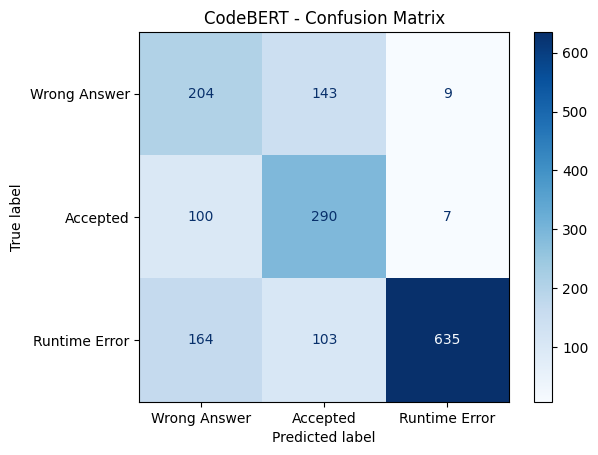

In [ ]:
# Get predictions
codebert_preds_output = trainer.predict(tokenised["test"])
codebert_preds = np.argmax(codebert_preds_output.predictions, axis=1)
codebert_labels = codebert_preds_output.label_ids

# calculate confusion matrix
cm_codebert = confusion_matrix(codebert_labels, codebert_preds)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_codebert,
                              display_labels=["Wrong Answer", "Accepted", "Runtime Error"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("CodeBERT - Confusion Matrix")
plt.show()


In [ ]:
#reload best model for test
best_ckpt = Path(trainer.state.best_model_checkpoint)
best_model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)
best_model.to(trainer.args.device).eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
#sample 5 to display
sample_df = test_df.sample(5, random_state=0).reset_index(drop=True)
texts = list(sample_df["code"])


In [ ]:
# Tokenize the selected code snippets
tokenized = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)
# Move each tensor to the model device
tokenized = {k: v.to(trainer.args.device) for k, v in tokenized.items()}

In [ ]:
with torch.no_grad():
    logits = best_model(**tokenized).logits

probs = F.softmax(logits, dim=-1).cpu().numpy()
preds = probs.argmax(axis=-1)

In [ ]:
# Define label names
label_names = {0: "wrong_answer", 1: "accepted", 2: "runtime_error"}

# sampled code and its predicted probabilities
for i, (code, prob_row, pred) in enumerate(zip(texts, probs, preds)):
    print(f"\n=== SAMPLE {i+1} ===")
    # Display the first 250 characters of the code
    print(code[:250].replace("\n", " ") + (" ..." if len(code) > 250 else ""))

    # Print class probabilities
    print("Class probabilities:")
    for label_id, prob in enumerate(prob_row):
        print(f"  {label_names[label_id]:<15}: {prob:.3f}")

    # Print final prediction
    print(f"→ Prediction: {label_names[pred]}")



=== SAMPLE 1 ===
s=input() cnt=0 for i in range(4): 	if s[i]=='+': 		cnt=cnt+1 	else:       cnt=cnt-1        print(cnt)
Class probabilities:
  wrong_answer   : 0.004
  accepted       : 0.004
  runtime_error  : 0.992
→ Prediction: runtime_error

=== SAMPLE 2 ===
X = int(input()) A = 0 for i in range(X):     if i != 0:         A = A + (X - 1) // i print(A) 
Class probabilities:
  wrong_answer   : 0.749
  accepted       : 0.192
  runtime_error  : 0.060
→ Prediction: wrong_answer

=== SAMPLE 3 ===
m1, d1 = map(int, input().strip().split(" ")) m2, d2 = map(int, input().strip().split(" ")) print("1" if m1 != m2 else "0") 
Class probabilities:
  wrong_answer   : 0.184
  accepted       : 0.787
  runtime_error  : 0.029
→ Prediction: accepted

=== SAMPLE 4 ===
from math import log  k, a, b = [int(i) for i in input().split()]  N = []  for n in range(1, (k + 1) // a + 1):     x = n * a - 1     # y = int(log((b/a-1)*k+1, b/a))     # z = y     # m = 1 + x - a*y + b*z     # y = y+1     # z= z+1     

In [ ]:
#base bert model for comparision
model_ckpt = "bert-base-uncased"

In [ ]:
# Polars → numeric 3-class labels
df = (
    df.select(["code", "status"])   # ✅ already renamed earlier
      .with_columns(
          pl.col("status").replace({
              "Wrong Answer": 0,
              "Accepted": 1,
              "Runtime Error": 2
          }).cast(pl.Int8).alias("label")
      )
)

# Polars → pandas for sklearn splitting
data_f = df.to_pandas()
train_df, temp_df = train_test_split(
    data_f, test_size=0.2, random_state=42, stratify=data_f["label"]
)
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

def to_ds(p):                      # pandas → HF Dataset
    return Dataset.from_pandas(p, preserve_index=False)

train_ds, valid_ds, test_ds = map(to_ds, (train_df, valid_df, test_df))


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(ex):
    return tokenizer(ex["code"],
                     padding="max_length",
                     truncation=True,
                     max_length=256)      # adjust if needed

train_ds  = train_ds.map(tokenize, batched=True)
valid_ds  = valid_ds.map(tokenize, batched=True)
test_ds   = test_ds.map(tokenize, batched=True)

cols_to_remove = ["code", "status"] if "status" in train_ds.column_names else ["code"]
for ds in (train_ds, valid_ds, test_ds):
    ds = ds.remove_columns(cols_to_remove)  # keeps label + encodings


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/13232 [00:00<?, ? examples/s]

Map:   0%|          | 0/1654 [00:00<?, ? examples/s]

Map:   0%|          | 0/1655 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=3,
    id2label={0: "wrong_answer", 1: "accepted", 2: "runtime_error"},
    label2id={"wrong_answer": 0, "accepted": 1, "runtime_error": 2},
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
cnt         = Counter(train_df["label"])
tot         = sum(cnt.values())
weights     = [tot / (3 * cnt[i]) for i in range(3)]
class_wts   = torch.tensor(weights, dtype=torch.float)


In [ ]:
from transformers import Trainer, TrainerCallback

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.get("labels")
        outputs = model(**inputs)
        logits  = outputs.get("logits")
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss    = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


In [ ]:
training_args = TrainingArguments(
    output_dir="bert-base-runs",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    logging_steps=100,
    seed=42
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_wts
)

trainer.train()


/tmp/ipython-input-33-3850170303.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


TrainOutput(global_step=16540, training_loss=0.5573741600908421, metrics={'train_runtime': 1649.9759, 'train_samples_per_second': 80.195, 'train_steps_per_second': 10.024, 'total_flos': 1.740758371688448e+16, 'train_loss': 0.5573741600908421, 'epoch': 10.0})

In [ ]:
metrics = trainer.evaluate(test_ds)
print(metrics)



{'eval_loss': 0.9137625694274902, 'eval_accuracy': 0.6471299093655589, 'eval_precision': 0.6005708107172542, 'eval_recall': 0.604336114830519, 'eval_f1': 0.5981017895412909, 'eval_runtime': 3.7832, 'eval_samples_per_second': 437.459, 'eval_steps_per_second': 54.715, 'epoch': 10.0}


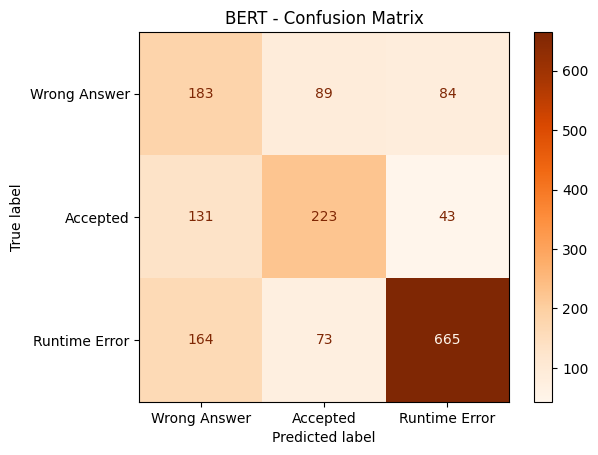

In [ ]:
# Get predictions
bert_preds_output = trainer.predict(test_ds)
bert_preds = np.argmax(bert_preds_output.predictions, axis=1)
bert_labels = bert_preds_output.label_ids

# Compute confusion matrix
cm_bert = confusion_matrix(bert_labels, bert_preds)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bert,
                              display_labels=["Wrong Answer", "Accepted", "Runtime Error"])
disp.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title("BERT - Confusion Matrix")
plt.show()
